In [56]:
#import all packages
import numpy as np
import random
import re
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix

# Performance metrics
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score


from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
# used to cache results
import time
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
import pickle

import warnings
warnings.filterwarnings('ignore')

In [78]:
'''
Utility functions
'''
#Define functions for pipeline
#Feature Extraction
min_df = [3]
#lemmatization_tokenizer
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
    
def lemmatized_tokenizer(text):
    wnl = WordNetLemmatizer()
    clean_text = re.sub(r'[^A-Za-z]', " ", text)
    tokenized_text = nltk.word_tokenize(clean_text) 
    lemaitzed_text = [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(tokenized_text)]
    return lemaitzed_text

#general_tokenizer
def tokenizer(text):
    clean_text = re.sub(r'[^A-Za-z]', " ", text)
    tokenized_text = nltk.word_tokenize(clean_text)
    return tokenized_text

# define data loader
def data_loader(categories, random_state, remove_flag):
    if remove_flag:
        train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = random_state, remove = ('headers', 'footers', 'quotes'))
        test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = random_state, remove = ('headers', 'footers', 'quotes'))
    else:
        train_dataset = fetch_20newsgroups(subset = 'train', categories = categories, shuffle = True, random_state = random_state)
        test_dataset = fetch_20newsgroups(subset = 'test', categories = categories, shuffle = True, random_state = random_state)

    return train_dataset, test_dataset

# define data processor
def data_processor(train_set, test_set, min_df, tokenizer, stop_words, dim_reduction_flag, dim_reduction_method, r):
    vectorizer = CountVectorizer(min_df = min_df, tokenizer = tokenizer, lowercase=True, stop_words = stop_words)
    if type(train_set) == list:
        X_train_counts = vectorizer.fit_transform(train_set)
        X_test_counts = vectorizer.transform(test_set)
    else: 
        X_train_counts = vectorizer.fit_transform(train_set.data)
        X_test_counts = vectorizer.transform(test_set.data)

    ##tf-idf
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)

    ##dimension reduction
    if dim_reduction_flag:
        if dim_reduction_method == 'SVD':
            svd = TruncatedSVD(n_components = r, random_state = 0)
            X_train_tfidf = svd.fit_transform(X_train_tfidf)
            X_test_tfidf = svd.transform(X_test_tfidf)   
        elif dim_reduction_method == 'NMF':
            nmf = NMF(n_components = r, random_state = 0)
            X_train_tfidf = nmf.fit_transform(X_train_tfidf)
            X_test_tfidf = nmf.transform(X_test_tfidf) 

    return X_train_tfidf, X_test_tfidf

# define the plot of contingency matrix
def plot_contingency_matrix(y_true, y_pred, fig_size, fontsize, classes,title,cmap=plt.cm.Blues, normalize=False):
    matrix = contingency_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.imshow(matrix, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(matrix.shape[1]),
           yticks=np.arange(matrix.shape[0]),
           xticklabels=classes, yticklabels=classes)
    plt.xticks(np.arange(matrix.shape[1]),fontsize = fontsize)
    plt.yticks(np.arange(matrix.shape[0]),fontsize = fontsize)
    ax.set_title(title,fontweight="bold", size = fontsize) # Title
    ax.set_ylabel('True label', fontsize = fontsize) # Y label
    ax.set_xlabel('Predicted label', fontsize = fontsize) # X label

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, format(matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if matrix[i, j] > thresh else "black")
    fig.tight_layout()
    return matrix

def performance_metrics(labels_true, labels_pred, printflag = True):
    h_score = homogeneity_score(labels_true, labels_pred)
    c_score = completeness_score(labels_true, labels_pred)
    v_score = v_measure_score(labels_true, labels_pred)
    ar_score = adjusted_rand_score(labels_true, labels_pred)
    ami_score = adjusted_mutual_info_score(labels_true, labels_pred)

    if printflag:
        print('The Homogeneity score is %.4f'%h_score)
        print('The Completeness score is %.4f'%c_score)
        print('The V-measure score is %.4f'%v_score)
        print('The Adjusted Rand Index score is %.4f'%ar_score)
        print('The Adjusted Mutual Information score is %.4f'%ami_score)
    
    return h_score, c_score, v_score, ar_score, ami_score

In [44]:
#prepare train/test dataset
computer_technology = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
recreational_activity = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

com_train, com_test = data_loader(categories = computer_technology, random_state = 42, remove_flag = True)
rec_train, rec_test = data_loader(categories = recreational_activity, random_state = 42, remove_flag = True)
train_dataset, test_dataset = com_train.data + rec_train.data, com_test.data + rec_test.data
y_train, y_test = [0] * len(comp_train.data) + [1] * len(rec_train.data), [0] * len(comp_test.data) + [1] * len(rec_test.data)

## Question 1
Following the steps in Project 1, transform the documents into TF-IDF vectors. Use min df = 3, exclude the stopwords (no need to do stemming or lemmatization).

### QUESTION 1: Report the dimensions of the TF-IDF matrix you get

In [79]:
# perform tf-idf transformation, without stemming or lemmatization
X_train_tfidf, X_test_tfidf = data_processor(train_dataset, test_dataset, min_df = 3, tokenizer = tokenizer, stop_words = 'english', dim_reduction_flag = False, dim_reduction_method = None, r = None)

print("The shape of TF-IDF matrix of training set:",X_train_tfidf.shape)
print("The shape of TF-IDF matrix of testing set:",X_test_tfidf.shape)

The shape of TF-IDF matrix of training set: (4732, 11389)
The shape of TF-IDF matrix of testing set: (3150, 11389)


## Question 2
Apply K-means clustering with k = 2 using the TF-IDF data. Note that the KMeans class in sklearn has parameters named random state, max iter and n init. Please use 1
random state=0, max iter ≥ 1000 and n init ≥ 30 . Compare the clustering results with the known class labels.

In [47]:
kmeans = KMeans(n_clusters = 2, random_state = 0, max_iter = 1000, n_init = 30)
kmeans.fit(X_train_tfidf)
y_train_pred = kmeans.predict(X_train_tfidf)

### QUESTION 2: Report the contingency table of your clustering result.

The contingency matrix of Kmeans clustering is [[1677  666]
 [  41 2348]]


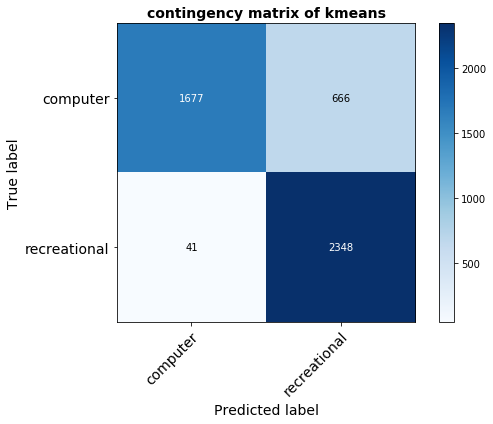

In [58]:
cm_q2 = plot_contingency_matrix(y_train, y_train_pred, fig_size = (8,6), fontsize = 14, classes = ['computer', 'recreational'], title = 'contingency matrix of kmeans', cmap=plt.cm.Blues, normalize=False)
print('The contingency matrix of Kmeans clustering is', cm_q2)

### QUESTION 3: Report the 5 measures above for the K-means clustering results you get.

In [59]:
performance_metrics(y_train, y_train_pred, printflag = True)

The Homogeneity score is 0.4556
The Completeness score is 0.4820
The V-measure score is 0.4684
The Adjusted Rand Index score is 0.4916
The Adjusted Mutual Information score is 0.4555


(0.4556156240535208,
 0.4820011434110125,
 0.4684371256362499,
 0.4915552011145086,
 0.4555325904432599)

## Question 3
As you may have observed, high dimensional sparse TF-IDF vectors do not yield a good clustering result. One of the reasons is that in a high-dimensional space, the Euclidean distance is not a good metric anymore, in the sense that the distances between data points tends to be almost the same (see [1]).
K-means clustering has other limitations. Since its objective is to minimize the sum of within-cluster l2 distances, it implicitly assumes that the clusters are isotropically shaped, i.e. round-shaped. When the clusters are not round-shaped, K-means may fail to identify the clusters properly. Even when the clusters are round, K-means algorithm may also fail when the clusters have unequal variances. A direct visualization for these problems can be found at sklearn - Demonstration of k-means assumptions.
In this part we try to find a “better” representation tailored to the way that K-means clustering algorithm works, by reducing the dimension of our data before clustering.
We will use Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) that you are already familiar with for dimensionality reduction.

### QUESTION 4: Report the plot of the percent of variance the top r principle compo- nents can retain v.s. r, for r = 1 to 1000.

In [76]:
svd = TruncatedSVD(n_components=1000)
svd.fit_transform(X_train_tfidf)
variance_ratios = svd.explained_variance_ratio_
accumulated_ratios = np.cumsum(variance_ratios)

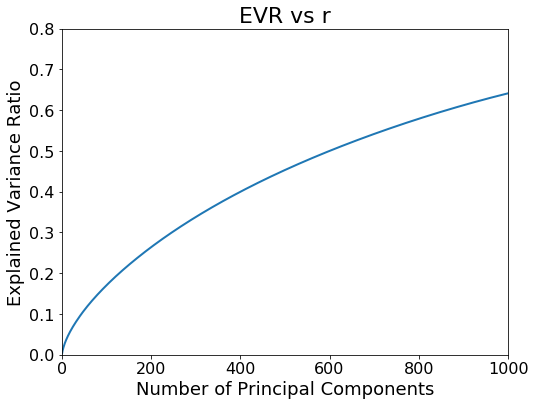

In [77]:
plt.figure(figsize=(8,6))
plt.xlim([0, 1000])
plt.ylim([0.0, 0.8])
plt.xlabel('Number of Principal Components', fontsize=18)
plt.ylabel('Explained Variance Ratio', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('EVR vs r', fontsize=22)
plt.plot(range(1,1001), accumulated_ratios, lw=2)
plt.show()

### QUESTION 5: Let r be the dimension that we want to reduce the data to (i.e. n components).
Try r = 1,2,3,5,10,20,50,100,300, and plot the 5 measure scores v.s. r for both
SVD and NMF. Report a good choice of r for SVD and NMF respectively.
Note: In the choice of r, there is a trade-off between the information preservation, and better performance of k-means in lower dimensions.

In [82]:
rs = [1,2,3,5,10,20,50,100,300]
method = ['SVD', 'NMF']
h_score, c_score, v_score, ar_score, ami_score = [], [], [], [], []
for m in method:
    for r in rs:
        X_train_reduced, X_test_reduced = data_processor(train_dataset, test_dataset, min_df = 3, tokenizer = tokenizer, stop_words = 'english', dim_reduction_flag = True, dim_reduction_method = m, r = r)
        kmeans = KMeans(n_clusters = 2, random_state = 0, max_iter = 1000, n_init = 30)
        kmeans.fit(X_train_reduced)
        y_pred = kmeans.predict(X_train_reduced)
        h, c, v, a, am = performance_metrics(y_train, y_pred, printflag = False)
        h_score.append(h)
        c_score.append(c)
        v_score.append(v)
        ar_score.append(a)
        ami_score.append(am)


In [85]:
ax, fig = plt.subplot(1, 2)
plt.plot(rs, h_score[0:len(rs)])


ValueError: Illegal argument(s) to subplot: (1, 2)

<Figure size 432x288 with 0 Axes>